# Sea ice area anomaly time series using OSISAF data

In [23]:
#input data

# climatology range
clst = 1979 ;clen = 2008

#input path
src  = 'OSISAF'
diri = '/g/data/gv90/wrh581/'+src+'/'
iNam = 'ice_conc'

#output path
diro = '/g/data/jk72/wrh581/Obs-seaice-analysis/plots/'
filo = src+'_totalSIA_tplot.png'

In [2]:
#import libraries 
import xarray as xr
import cf_xarray as cf
import matplotlib.pyplot as plt
import numpy as np

#### read data

In [29]:
cmd = 'ls '+diri+'*.nc'#ice_conc_sh_ease2-250_*.nc'
fpath = !$cmd

data = xr.open_mfdataset(fpath, chunks = -1, parallel=True).compute()
data



<xarray.Dataset> Size: 2GB
Dimensions:                 (time: 558, yc: 432, xc: 432, nv: 2)
Coordinates:
  * time                    (time) datetime64[ns] 4kB 1978-11-16T12:00:00 ......
  * xc                      (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 746kB -16.62 -16.82 ... -16.62
    lon                     (yc, xc) float32 746kB -45.0 -44.87 ... 135.1 135.0
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid  (time) int32 2kB -2147483647 ... -2147483647
    ice_conc                (time, yc, xc) float64 833MB nan nan nan ... nan nan
    raw_ice_conc_values     (time, yc, xc) float64 833MB nan nan nan ... nan nan
    status_flag             (time, yc, xc) float32 417MB 1.0 1.0 1.0 ... 1.0 1.0
    time_bnds               (time, nv) datetime64[ns] 9kB 1978-11-01 ... 2025...
Attributes: (12/43)
    title:                     Monthly Sea Ice Concentration Climate Data Rec...
    summary:                   This climate data record of sea ice concentrat...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    geospatial_lat_min:        -90.0
    geospatial_lat_max:        -16.62393
    geospatial_lon_min:        -180.0
    ...                        ...
    algorithm:                 SICCI3LF (19V, 37V, 37H)
    references:                Product User Manual v3 (2022),Algorithm Theore...
    contributor_name:          Thomas Lavergne,Atle Soerensen,Rasmus Tonboe,C...
    contributor_role:          PrincipalInvestigator,author,author,author,aut...
    source:                    FCDR of SMMR / SSMI / SSMIS Brightness Tempera...
    product_status:            released

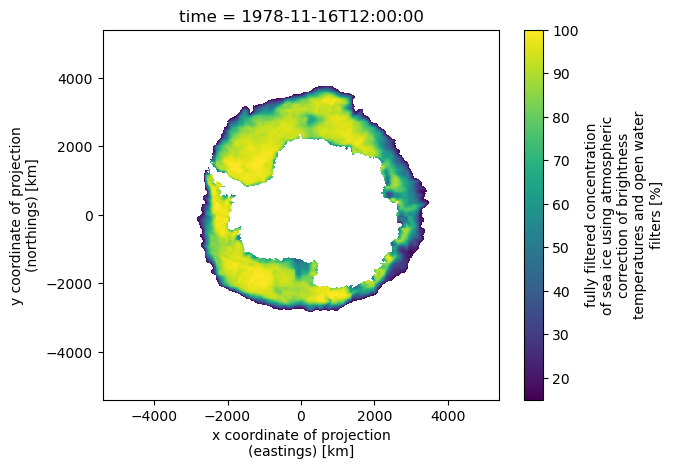

In [32]:
data[iNam][0,:,:].plot()

#### Calc SIA

In [39]:
# grid is a 25km equal area, units are percent
A = 25**2. * 1.e-6 * 0.01   #will convert to million km


#SIA
data[iNam] = data[iNam].where(data[iNam] > 15.)
SIA = (data[iNam] * A).sum((data.cf['X'].name, data.cf['Y'].name))


#SIE
data[iNam].values = np.where(np.isnan(data[iNam].values),0., 100.)
SIE =  (data[iNam] * A * 100.).sum((data.cf['X'].name, data.cf['Y'].name))

#### plot

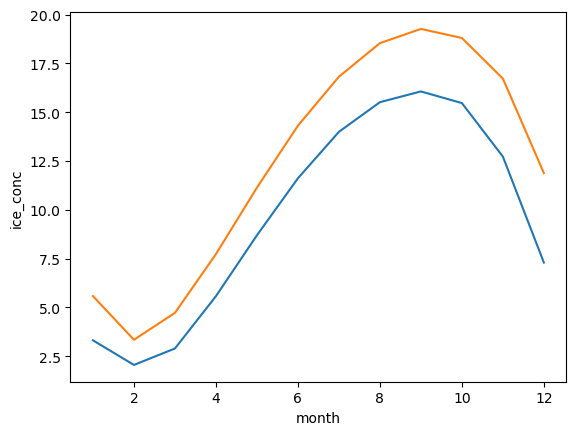

In [44]:
SIA.groupby('time.month').mean('time').plot()
SIE.groupby('time.month').mean('time').plot()


In [47]:
SIA = SIA.groupby('time.month') - SIA.sel(time = slice(str(clst),str(clen))).groupby('time.month').mean('time')

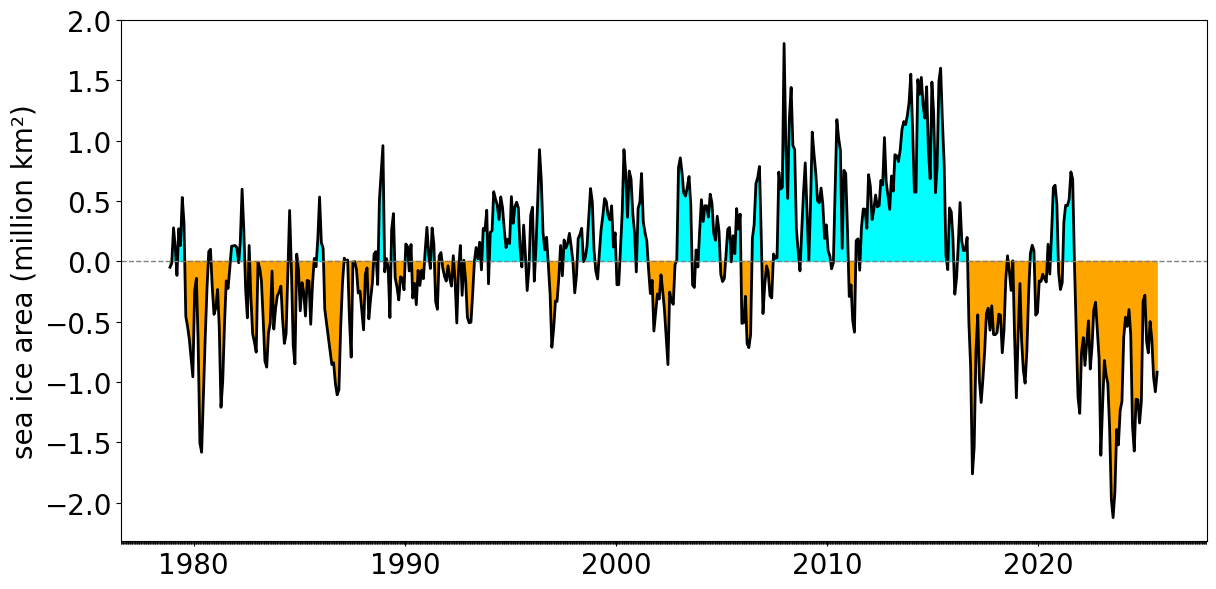

In [59]:




# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

ax.tick_params(axis='x', labelsize=20)  # Change x-axis tick label size
ax.tick_params(axis='y', labelsize=20)


# Plot the sea ice area anomalies
ax.plot(SIA.time, SIA.values, color='black', linewidth=2, label='Sea Ice Area Anomaly')

# Shade positive and negative anomalies
ref_line = 0.
ax.fill_between(SIA.time, SIA.values, ref_line, where=SIA.values > ref_line, interpolate=True, color='cyan', label='Positive Anomaly')
ax.fill_between(SIA.time, SIA.values, ref_line, where=SIA.values < ref_line, interpolate=True, color='orange', label='Negative Anomaly')

# Add reference line
ax.axhline(ref_line, color='gray', linestyle='--', linewidth=1)



# Axis labels and title
ax.set_ylabel(f"sea ice area (million km²)", fontsize = 20.)



# Save the plot
plt.tight_layout()
#plt.savefig("sea_ice_area_anomalies.png")
plt.show()

In [60]:
SIA = SIA.groupby('time.month')/SIA.sel(time = slice(str(clst),str(clen))).groupby('time.month').std('time')

Text(0, 0.5, 'sigma')

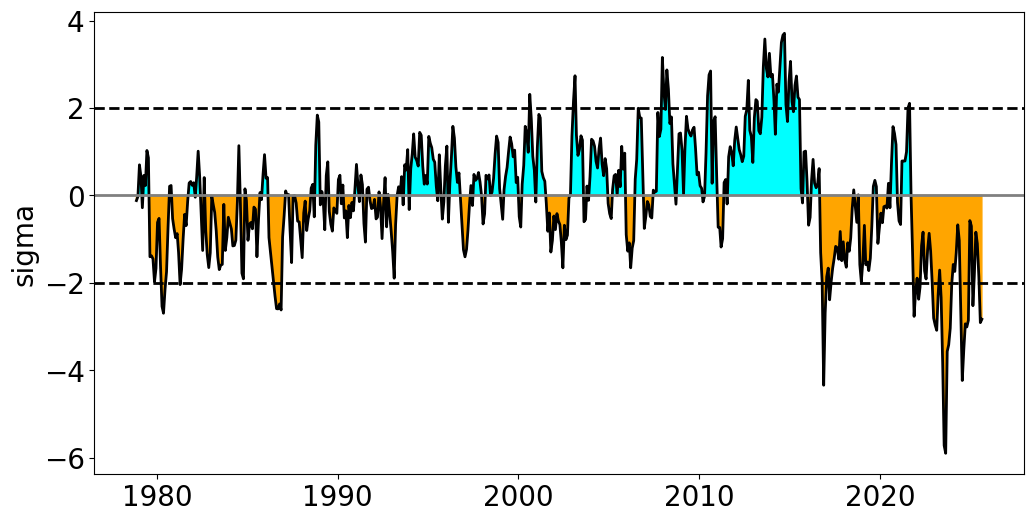

In [63]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

ax.tick_params(axis='x', labelsize=20)  # Change x-axis tick label size
ax.tick_params(axis='y', labelsize=20)


# Plot the sea ice area anomalies
ax.plot(SIA.time, SIA.values, color='black', linewidth=2, label='Sea Ice Area Anomaly')

# Shade positive and negative anomalies
ref_line = 0.
ax.fill_between(SIA.time, SIA.values, ref_line, where=SIA.values > ref_line, interpolate=True, color='cyan', label='Positive Anomaly')
ax.fill_between(SIA.time, SIA.values, ref_line, where=SIA.values < ref_line, interpolate=True, color='orange', label='Negative Anomaly')

# Add reference lines
ax.axhline(0., color='gray', linestyle='-', linewidth=2)
ax.axhline(2., color='black', linestyle='--', linewidth=2.)
ax.axhline(-2., color='black', linestyle='--', linewidth=2.)

# Axis labels and title
ax.set_ylabel(f"sigma", fontsize = 20.)

### write to file